# Using word2vec to Color Words

In [30]:
import json
import nlp

import pandas as pd
import numpy as np

from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline 

dataset = 'asm' # lss/asm
input_file = '../data/lss-17k.json'
output_file = '../data/lss-17k-color-lookup.json'

if dataset == 'asm':
    input_file = '../data/lss_asm_dataset.txt'
    output_file = '../data/lss-asm-color-lookup.json'

###  Load data

In [2]:
def load(filename):
    'A text file with each line as a JSON text.'
    p = parse_asm if dataset == 'asm' else parse_lss
    with open(filename) as file:
        sessions = [p(line) for line in file]
    return [s for s in sessions if s]

def parse_asm(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actions' in obj and obj['actions']:
        action = [a['name'][6:] for a in obj['actions']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['session']['dcxID'], 'action': action }

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue']:
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'action': action }

In [3]:
data = load(input_file)
docs = [d['action'] for d in data]
len(data), data[0]

(19351,
 {'action': ['SearchUsr',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'TabBar'],
  'id': '2LK1J5ID313Q1BWKN##NAGHU91'})

### word2vec

In [4]:
word2vec = nlp.build_word2vec(docs)
wordvecs = word2vec.wv

We can apply t-sne projection to show all terms in the dictionary and highlight the 26 ones in the clustering result.

In [14]:
actions = ["CreateLoginArea", "AddNewLoginArea", "TabBar", "SearchUsr", "DisplayOneUser", "CreateUser", "CloseTab", "AssignRole1", "AssignRole2", "SearchOffice", "DisplayOneOffice", "DisplayOrgaDetails", "EditLoginArea", "UpdateLogAreaIndic", "AdminOguStep1", "AddOfficeDodFinish", "AssignAcl2", "AssignAcl1", "AssignACLStep3", "SearchRoleForAssignRoleAcl", "UpdateUserDetails", "UnLockUser", "ResetPwdUnlock", "DisplayOneAppli", "TpfMassImport", "TpfRefreshTable"]

In [23]:
matrix = np.concatenate([wordvecs[t].reshape(1, -1) for t in actions])
coords = manifold.TSNE(perplexity=100, random_state=0).fit_transform(matrix)

In [34]:
ss = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(coords)
    ss.append(km.inertia_)

Text(0.5,1,'Elbow Method For Optimal k')

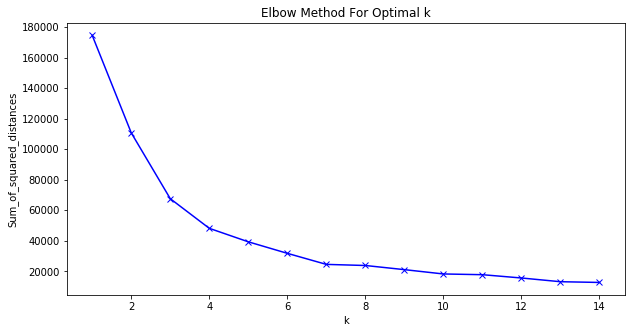

In [35]:
plt.figure(figsize=(10,5))
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

Let's choose 5 clusters and visualise them.

In [28]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(coords)

In [37]:
pd.DataFrame({ 'name': actions, 'label': labels })

,label,name
0,4,CreateLoginArea
1,4,AddNewLoginArea
2,2,TabBar
3,3,SearchUsr
4,4,DisplayOneUser
5,1,CreateUser
6,4,CloseTab
7,3,AssignRole1
8,0,AssignRole2
9,2,SearchOffice


### Export RGB colors of terms

In [34]:
terms = list(wordvecs.vocab.keys())
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors]
color_lookup = {terms[i]:c for i, c in enumerate(hex_colors)} 

with open(output_file, 'w') as f:
    json.dump(color_lookup, f)